# フィラデルフィア半導体株指数 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'SOX'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-03-27 00:00:00-04:00,4902.279785,4903.180176,4815.060059,4899.950195,0,0.0,0.0
2024-03-28 00:00:00-04:00,4892.450195,4926.759766,4887.089844,4905.209961,0,0.0,0.0
2024-04-01 00:00:00-04:00,4921.529785,5030.520020,4919.970215,4962.100098,0,0.0,0.0
2024-04-02 00:00:00-04:00,4883.560059,4898.120117,4834.220215,4886.939941,0,0.0,0.0
2024-04-03 00:00:00-04:00,4838.080078,4938.330078,4831.529785,4903.500000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-20 00:00:00-04:00,4579.060059,4648.459961,4575.450195,4601.370117,0,0.0,0.0
2025-03-21 00:00:00-04:00,4514.399902,4570.410156,4484.479980,4557.950195,0,0.0,0.0
2025-03-24 00:00:00-04:00,4662.899902,4722.479980,4657.330078,4694.220215,0,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-28 00:00:00-04:00,3501.790039,3548.540039,3450.939941,3547.169922,0,0.0,0.0
2022-03-29 00:00:00-04:00,3601.370117,3633.139893,3557.659912,3625.580078,0,0.0,0.0
2022-03-30 00:00:00-04:00,3605.260010,3611.199951,3493.689941,3508.620117,0,0.0,0.0
2022-03-31 00:00:00-04:00,3503.739990,3523.699951,3427.469971,3429.000000,0,0.0,0.0
2022-04-01 00:00:00-04:00,3454.070068,3455.800049,3317.879883,3366.639893,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-20 00:00:00-04:00,4579.060059,4648.459961,4575.450195,4601.370117,0,0.0,0.0
2025-03-21 00:00:00-04:00,4514.399902,4570.410156,4484.479980,4557.950195,0,0.0,0.0
2025-03-24 00:00:00-04:00,4662.899902,4722.479980,4657.330078,4694.220215,0,0.0,0.0


## Moving Median

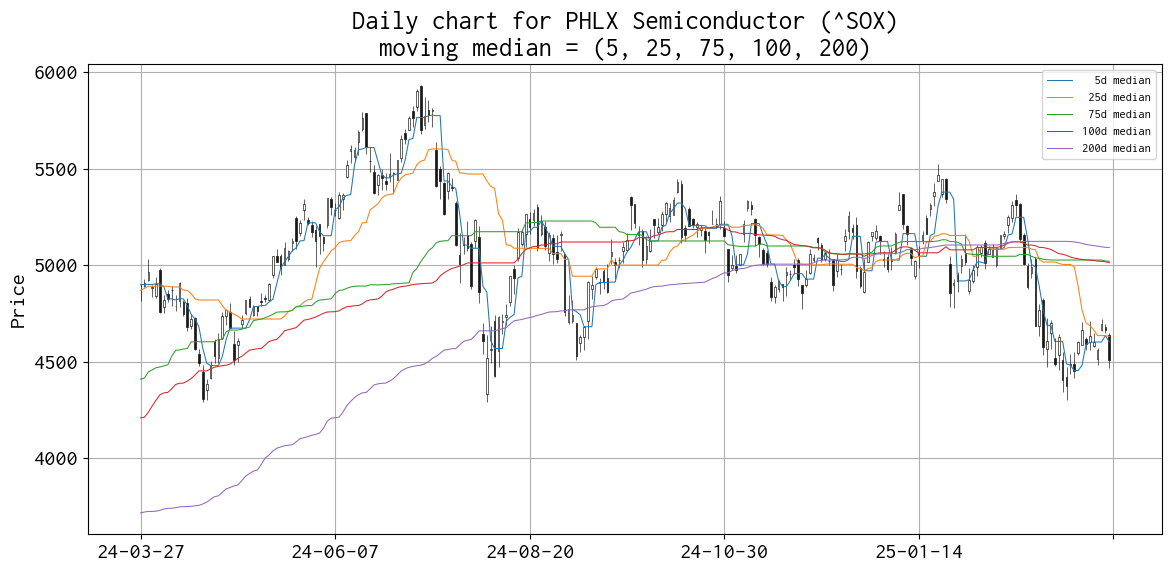

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))
"""
fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()
"""

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-25 00:00:00-04:00,4679.879883,4693.200195,4648.799805,4661.339844,0,0.0,0.0
2025-03-26 00:00:00-04:00,4639.919922,4649.543457,4467.711426,4508.741699,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-25 00:00:00-04:00    4661.339844
2025-03-26 00:00:00-04:00    4508.741699
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-25 00:00:00-04:00           NaN
2025-03-26 00:00:00-04:00   -152.598145
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-26 00:00:00-04:00   -131.178223
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-20 00:00:00-04:00    4589.029785
2025-03-21 00:00:00-04:00    4589.029785
2025-03-24 00:00:00-04:00    4598.790039
2025-03-25 00:00:00-04:00    4601.370117
2025-03-26 00:00:00-04:00    4601.370117
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-20 00:00:00-04:00    4598.790039
2025-03-21 00:00:00-04:00    4589.029785
2025-03-24 00:00:00-04:00    4589.029785
2025-03-25 00:00:00-04:00    4598.790039
2025-03-26 00:00:00-04:00    4589.029785
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-20 00:00:00-04:00    4675.360107
2025-03-21 00:00:00-04:00    4649.250000
2025-03-24 00:00:00-04:00    4649.250000
2025-03-25 00:00:00-04:00    4647.934814
2025-03-26 00:00:00-04:00    4632.059814
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-20 00:00:00-04:00    5017.945068
2025-03-21 00:00:00-04:00    5012.594971
2025-03-24 00:00:00-04:00    5006.439941
2025-03-25 00:00:00-04:00    4997.179932
2025-03-26 00:00:00-04:00    4983.704834
Name: Close, dtype: float64

## Robust Bollinger's bands

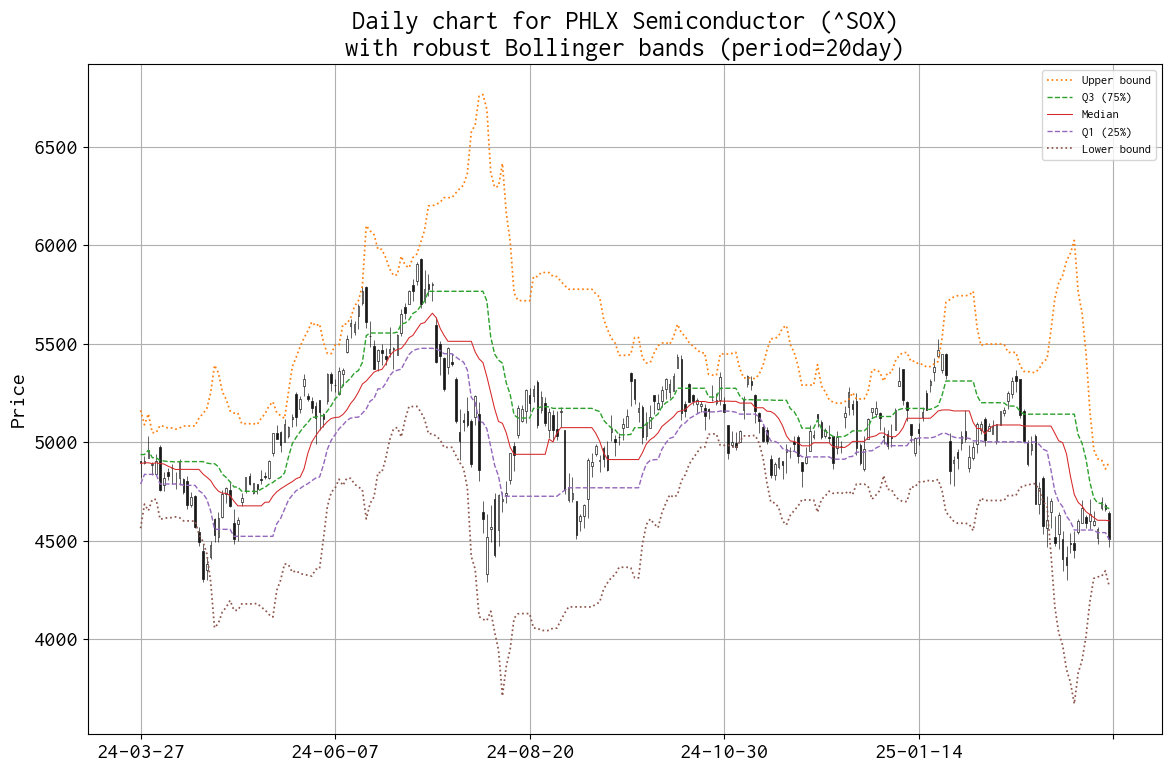

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

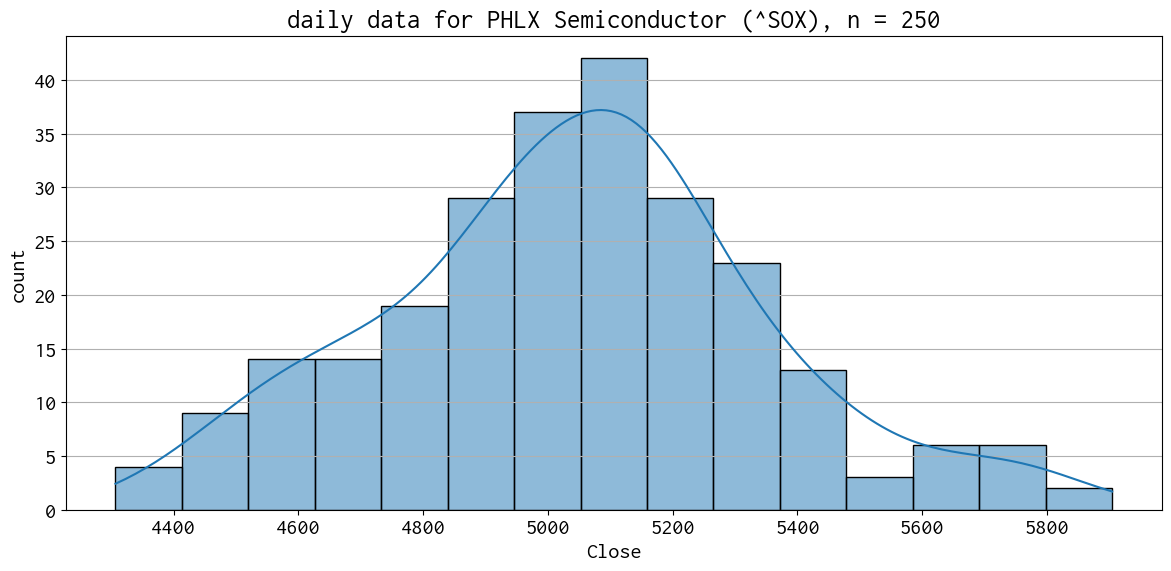

In [14]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(12, 6))
#ax = fig.add_axes(111)
ax = fig.add_subplot(111)

sns.histplot(
    df['Close'],
    kde=True,
    ax=ax
)

ax.set_xlabel("Close")
ax.set_ylabel("count")
ax.set_title('daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)))
ax.grid(axis = 'y')

plt.tight_layout()
plt.savefig('report_daily_histogram_%s.png' % code)
plt.show()